<a href="https://colab.research.google.com/github/flohmannjr/tensorflow_curso/blob/main/TensorFlow_TL2_Fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TensorFlow Transfer Learning Fine-tuning

In [1]:
import tensorflow as tf
import tensorflow_hub as hub

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

import random
import os

from tensorflow.keras import Model, Sequential
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
# from tensorflow.keras.layers import Rescaling # Se for utilizar um modelo que não tenha escalonamento interno, como ResNet50V2, é necessário escalonar os dados.
from tensorflow.keras.layers import RandomFlip, RandomHeight, RandomRotation, RandomWidth, RandomZoom
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import image_dataset_from_directory

## Setup

In [2]:
plt.rcParams['figure.figsize'] = [8, 5]
plt.rcParams['figure.dpi'] = 100
plt.style.use('seaborn-darkgrid')

### Constantes

In [3]:
SEMENTE = 2008193

DIR_TREINO    = '10_food_classes_all_data/train'
DIR_TREINO_10 = '10_food_classes_10_percent/train'
DIR_TREINO_1  = '10_food_classes_1_percent/train'
DIR_TESTE     = '10_food_classes_all_data/test'

TAMANHO_LOTE = 32
FORMATO_IMAGEM = (224, 224)
MODO_CLASSE = 'categorical'

FORMATO_ENTRADA = FORMATO_IMAGEM + (3,)
ATIVACAO = 'softmax'

PERDA = 'categorical_crossentropy'
METRICAS = ['accuracy']

# OTIMIZADOR = 'Adam'
APRENDIZADO = 0.001
APRENDIZADO_RESINTONIZADO = 0.0001

ITERACOES = 5
ITERACOES_RESINTONIZADAS = ITERACOES + 5

### Funções

In [4]:
!wget https://raw.githubusercontent.com/flohmannjr/tensorflow_curso/main/funcoes.py

--2023-01-24 15:01:43--  https://raw.githubusercontent.com/flohmannjr/tensorflow_curso/main/funcoes.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4971 (4.9K) [text/plain]
Saving to: ‘funcoes.py’

funcoes.py          100%[===================>]   4.85K  --.-KB/s    in 0s      

2023-01-24 15:01:43 (72.0 MB/s) - ‘funcoes.py’ saved [4971/4971]



In [5]:
from funcoes import criar_callback_tensorboard, grafico_historico_por_iteracao, grafico_historicos_complementares, unzip_data, walk_through_dir

## Dados

In [6]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip

unzip_data('10_food_classes_all_data.zip')
unzip_data('10_food_classes_10_percent.zip')
unzip_data('10_food_classes_1_percent.zip')

--2023-01-24 15:01:43--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.128, 74.125.197.128, 74.125.195.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M   233MB/s    in 2.1s    

2023-01-24 15:01:46 (233 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]

--2023-01-24 15:01:46--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.128, 74.125.197.128, 74.125.195.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 

In [7]:
# walk_through_dir('10_food_classes_all_data')

### Importando os dados e tranformando-os em lotes

In [8]:
dados_treino = image_dataset_from_directory(directory=DIR_TREINO,
                                            batch_size=TAMANHO_LOTE,
                                            image_size=FORMATO_IMAGEM,
                                            label_mode=MODO_CLASSE,
                                            seed=SEMENTE)

dados_teste = image_dataset_from_directory(directory=DIR_TESTE,
                                           batch_size=TAMANHO_LOTE,
                                           image_size=FORMATO_IMAGEM,
                                           label_mode=MODO_CLASSE,
                                           seed=SEMENTE)

dados_treino_10 = image_dataset_from_directory(directory=DIR_TREINO_10,
                                               batch_size=TAMANHO_LOTE,
                                               image_size=FORMATO_IMAGEM,
                                               label_mode=MODO_CLASSE,
                                               seed=SEMENTE)

dados_treino_1 = image_dataset_from_directory(directory=DIR_TREINO_1,
                                              batch_size=TAMANHO_LOTE,
                                              image_size=FORMATO_IMAGEM,
                                              label_mode=MODO_CLASSE,
                                              seed=SEMENTE)

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.
Found 750 files belonging to 10 classes.
Found 70 files belonging to 10 classes.


In [9]:
# image_dataset_from_directory retorna um BatchDataset

# O primeiro tensor contém as imagens. DADOS NÃO ESCALONADOS.
# O tamanho do lote não está especificado, mesmo que tenha sido informado.
# Os canais de cores estão definidos pelo parâmetro color_mode='rgb' (default).

# O segundo tensor contém as classes em formato one-hot.

dados_treino

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [10]:
rotulos = dados_treino.class_names
# rotulos

## Criando Modelo_00

The Functional API: https://www.tensorflow.org/guide/keras/functional

Modelos pré-treinados: https://www.tensorflow.org/api_docs/python/tf/keras/applications

In [11]:
# Criar um modelo-base a partir de um modelo pré-treinado.
# EfficientNetB0 foi treinado com a ImageNet, portanto a camada no topo tem 1000 entradas.
# Nossos dados possuem 10 classes, portanto não utilizaremos a camada no topo padrão. (include_top=False)
modelo_base = EfficientNetB0(include_top=False)

# "Congelar" o modelo-base, para que os padrões pré-treinados não sejam odificados durante o treinamento.
modelo_base.trainable = False

# Camada de entrada.
entradas = Input(shape=FORMATO_ENTRADA, name='camada_entrada')

# Se for utilizar um modelo que não tenha escalonamento interno, como ResNet50V2, é necessário escalonar os dados.
# Modelos EfficientNet possuem escalonamento interno.
# camadas = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(entradas)
# Obs.: acredito que a camada de escalonamento devia ser adicionada à 'entradas', não 'camadas'.

# Carregar as entradas no modelo-base.
camadas = modelo_base(entradas)

# Agrupar a média global do modelo-base.
# Esta camada cria o vetor de características (feature vector).
camadas = GlobalAveragePooling2D(name='agrupamento_media_global')(camadas)

# Camada de saída.
saidas = Dense(len(rotulos), activation=ATIVACAO, name='camada_saida')(camadas)

# Reunir camadas de entrada e saída em um modelo.
modelo_00 = Model(inputs=entradas, outputs=saidas, name='Modelo_00')

# Compilar o modelo.
modelo_00.compile(loss=PERDA,
                  optimizer=Adam(learning_rate=APRENDIZADO),
                  metrics=METRICAS)

# Ajustar o modelo, gravando histórico e criando logs TensorBoard.
historico_00 = modelo_00.fit(dados_treino_10,
                             epochs=ITERACOES,
                             steps_per_epoch=len(dados_treino_10),
                             validation_data=dados_teste,
                             validation_steps=len(dados_teste),
                             callbacks=[criar_callback_tensorboard(diretorio='transfer_learning',
                                                                   experimento='modelo_00_10_por_cento')],
                             verbose=1)

16705208/16705208 [==============================] - 0s 0us/step
Salvando log TensorBoard em: 'transfer_learning/modelo_00_10_por_cento/20230124-150202'.
Epoch 1/5
24/24 [==============================] - 23s 399ms/step - loss: 1.9042 - accuracy: 0.3933 - val_loss: 1.3330 - val_accuracy: 0.7272
Epoch 2/5
24/24 [==============================] - 8s 311ms/step - loss: 1.1035 - accuracy: 0.7800 - val_loss: 0.8920 - val_accuracy: 0.8132
Epoch 3/5
24/24 [==============================] - 8s 310ms/step - loss: 0.7972 - accuracy: 0.8333 - val_loss: 0.7097 - val_accuracy: 0.8428
Epoch 4/5
24/24 [==============================] - 8s 313ms/step - loss: 0.6396 - accuracy: 0.8667 - val_loss: 0.6221 - val_accuracy: 0.8520
Epoch 5/5
24/24 [==============================] - 8s 309ms/step - loss: 0.5480 - accuracy: 0.8813 - val_loss: 0.5646 - val_accuracy: 0.8616


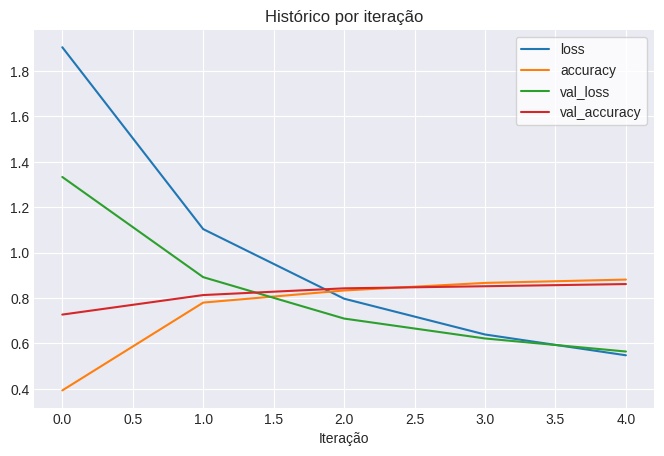

In [12]:
grafico_historico_por_iteracao(historico_00)

## Running a series of transfer learning experiments

We've seen the incredible results transfer learning can get with only 10% of the training data, but how does it go with 1% of the training data... how about we set up a bunch of experiments to find out:

1. `model_1` - use feature extraction transfer learning with 1% of the training data with data augmentation 
2. `model_2` - use feature extraction transfer learning with 10% of the training with data augmentaton 
3. `model_3` - use fine-tuning transfer learning on 10% of the training data with data augmentation
4. `model_4` - use fine-tuning transfer learning on 100% of the training data with data augmentation 

> 🔑 **Note:** throughout all experiments the same test dataset will be used to evaluate our model... this ensures consistency across evaluation metrics.

## Criando Modelo_01

### Expandindo dados

We can see the benefits of doing this within the TensorFlow Data augmentation documentation: https://www.tensorflow.org/tutorials/images/data_augmentation#use_keras_preprocessing_layers 

Off the top our of heads, after reading the docs, the benefits of using data augmentation inside the model are:
* Preprocessing of imges (augmenting them) happens on the GPU (much faster) rather than the CPU.
* Image data augmentation only happens during training, so we can still export our whole model and use it elsewhere.

In [13]:
expansao_dados = Sequential()

# expansao_dados.add(Rescaling(1./255)) # Se for utilizar um modelo que não tenha escalonamento interno, como ResNet50V2, é necessário escalonar os dados.

expansao_dados.add(RandomFlip('horizontal'))
expansao_dados.add(RandomRotation(0.2))
expansao_dados.add(RandomZoom(0.2))
expansao_dados.add(RandomHeight(0.2))
expansao_dados.add(RandomWidth(0.2))

#### Visualizando dados expandidos

In [14]:
# classe_aleatoria = random.choice(rotulos)
# caminho_classe   = DIR_TREINO_1 + '/' + classe_aleatoria
# imagem_aleatoria = random.choice(os.listdir(caminho_classe))
# caminho_imagem   = caminho_classe + '/' + imagem_aleatoria

# imagem = mpimg.imread(caminho_imagem)

# # imagem_expandida = expansao_dados(tf.expand_dims(imagem, axis=0))
# # Há um bug na versão 2.8 do TensorFlow que faz necessário forçar o treinamento para que a expansão dos dados funcione.
# imagem_expandida = expansao_dados(tf.expand_dims(imagem, axis=0), training=True)

# plt.title(f"Imagem original '{imagem_aleatoria}' ({classe_aleatoria})")
# plt.imshow(imagem)
# plt.axis(False)
# plt.show()

# plt.title(f"Imagem expandida")
# # plt.imshow(tf.squeeze(imagem_expandida))
# plt.imshow(tf.divide(tf.squeeze(imagem_expandida), 255.)) # Escalonamento para visualização
# plt.axis(False)
# plt.show()

### Modelo

Sobre `training=False` ao carregar os dados no `modelo_base`.

We make sure to pass training=False when calling the base model, so that it runs in inference mode, so that batchnorm statistics don't get updated even after we unfreeze the base model for fine-tuning.

https://keras.io/guides/transfer_learning/#build-a-model

In [15]:
modelo_base = EfficientNetB0(include_top=False)
modelo_base.trainable = False

entradas = Input(shape=FORMATO_ENTRADA, name='camada_entrada')

# Há um bug na versão 2.8 do TensorFlow que faz necessário forçar o treinamento para que a expansão dos dados funcione.
expandidos = expansao_dados(entradas, training=True)

camadas = modelo_base(expandidos, training=False)
camadas = GlobalAveragePooling2D(name='agrupamento_media_global')(camadas)

saidas = Dense(len(rotulos), activation=ATIVACAO, name='camada_saida')(camadas)

modelo_01 = Model(inputs=entradas, outputs=saidas, name='Modelo_01')

modelo_01.compile(loss=PERDA,
                  optimizer=Adam(learning_rate=APRENDIZADO),
                  metrics=METRICAS)

historico_01 = modelo_01.fit(dados_treino_1,
                             epochs=ITERACOES,
                             steps_per_epoch=len(dados_treino_1),
                             validation_data=dados_teste,
                             validation_steps=len(dados_teste),
                             callbacks=[criar_callback_tensorboard(diretorio='transfer_learning',
                                                                   experimento='modelo_01_1_por_cento_expandido')],
                             verbose=1)

Salvando log TensorBoard em: 'transfer_learning/modelo_01_1_por_cento_expandido/20230124-150307'.
Epoch 1/5
3/3 [==============================] - 37s 16s/step - loss: 2.5148 - accuracy: 0.0857 - val_loss: 2.3301 - val_accuracy: 0.1296
Epoch 2/5
3/3 [==============================] - 21s 10s/step - loss: 2.1552 - accuracy: 0.2571 - val_loss: 2.2048 - val_accuracy: 0.1928
Epoch 3/5
3/3 [==============================] - 22s 11s/step - loss: 2.0358 - accuracy: 0.2714 - val_loss: 2.0962 - val_accuracy: 0.2648
Epoch 4/5
3/3 [==============================] - 18s 9s/step - loss: 1.8118 - accuracy: 0.4714 - val_loss: 1.9946 - val_accuracy: 0.3440
Epoch 5/5
3/3 [==============================] - 18s 9s/step - loss: 1.6592 - accuracy: 0.5429 - val_loss: 1.9119 - val_accuracy: 0.3860


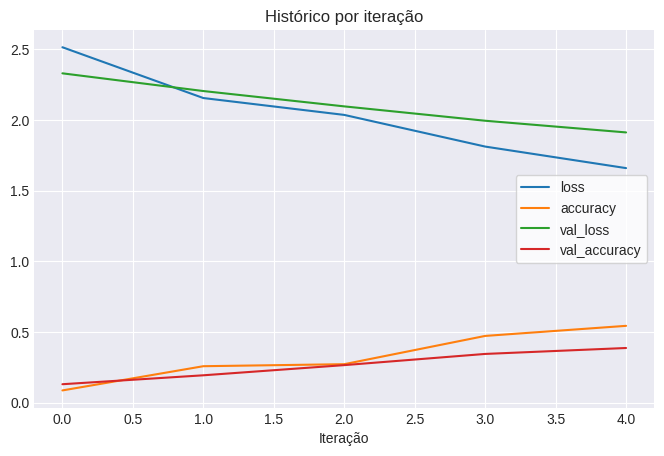

In [16]:
grafico_historico_por_iteracao(historico_01)

## Criando Modelo_02

In [17]:
modelo_base = EfficientNetB0(include_top=False)
modelo_base.trainable = False

entradas = Input(shape=FORMATO_ENTRADA, name='camada_entrada')

expandidos = expansao_dados(entradas, training=True)

camadas = modelo_base(expandidos, training=False)
camadas = GlobalAveragePooling2D(name='agrupamento_media_global')(camadas)

saidas = Dense(len(rotulos), activation=ATIVACAO, name='camada_saida')(camadas)

modelo_02 = Model(inputs=entradas, outputs=saidas, name='Modelo_02')

modelo_02.compile(loss=PERDA,
                  optimizer=Adam(learning_rate=APRENDIZADO),
                  metrics=METRICAS)

### Criando callback ModelCheckpoint

The ModelCheckpoint callback intermediately saves our model (the full model or just the weights) during training. This is useful so we can come and start where we left off.

In [18]:
# CAMINHO_CHECKPOINT = 'checkpoints/modelo_02'

# callback_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=CAMINHO_CHECKPOINT,  # Diretório onde os checkpoints serão salvos.
#                                                          save_weights_only=True,       # Salvar somente os pesos. (Se False, todo o modelo é salvo.)
#                                                          save_best_only=False,         # Salvar todos os modelos. (Se True, somente o melhor modelo é salvo.)
#                                                          save_freq='epoch',            # Salvar a cada iteração
#                                                          verbose=1)

### Ajustando o modelo

In [19]:
historico_02 = modelo_02.fit(dados_treino_10,
                             epochs=ITERACOES,
                             steps_per_epoch=len(dados_treino_10),
                             validation_data=dados_teste,
                             validation_steps=len(dados_teste),
                            #  callbacks=[criar_callback_tensorboard(diretorio='transfer_learning',
                            #                                        experimento='modelo_02_10_por_cento_expandido'),
                            #             callback_checkpoint],
                             callbacks=[criar_callback_tensorboard(diretorio='transfer_learning',
                                                                   experimento='modelo_02_10_por_cento_expandido')],
                             verbose=1)

Salvando log TensorBoard em: 'transfer_learning/modelo_02_10_por_cento_expandido/20230124-150537'.
Epoch 1/5
24/24 [==============================] - 30s 1s/step - loss: 2.0171 - accuracy: 0.3333 - val_loss: 1.5521 - val_accuracy: 0.6236
Epoch 2/5
24/24 [==============================] - 22s 932ms/step - loss: 1.3353 - accuracy: 0.6920 - val_loss: 1.1277 - val_accuracy: 0.7380
Epoch 3/5
24/24 [==============================] - 22s 951ms/step - loss: 1.0203 - accuracy: 0.7467 - val_loss: 0.9151 - val_accuracy: 0.7856
Epoch 4/5
24/24 [==============================] - 21s 876ms/step - loss: 0.8432 - accuracy: 0.8027 - val_loss: 0.8070 - val_accuracy: 0.7952
Epoch 5/5
24/24 [==============================] - 19s 809ms/step - loss: 0.7420 - accuracy: 0.8200 - val_loss: 0.7396 - val_accuracy: 0.8124


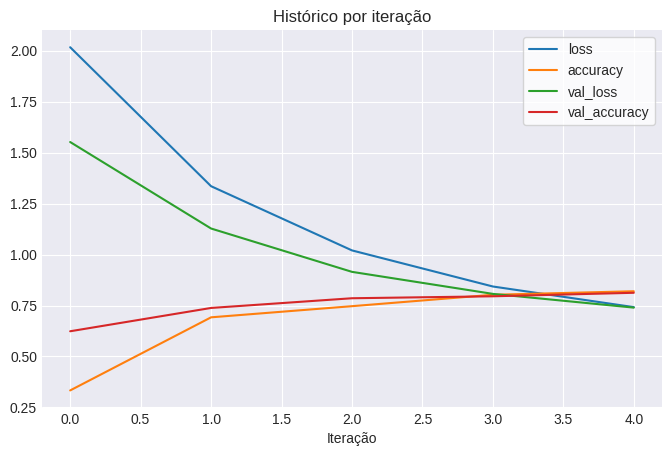

In [20]:
grafico_historico_por_iteracao(historico_02)

### Carregando os pesos salvos nos checkpoints

In [21]:
# # Validação modelo_02
# validacao_modelo_02_ajustado = modelo_02.evaluate(dados_teste)

In [22]:
# # Carregar os pesos retorna o modelo a um checkpoint.
# modelo_02.load_weights(CAMINHO_CHECKPOINT)

In [23]:
# # Validação modelo_02 após carregar os pesos
# validacao_modelo_02_carregado = modelo_02.evaluate(dados_teste)

In [24]:
# validacao_modelo_02_ajustado == validacao_modelo_02_carregado

In [25]:
# validacao_modelo_02_ajustado, validacao_modelo_02_carregado

In [26]:
# import numpy as np

# np.isclose(np.array(validacao_modelo_02_ajustado), np.array(validacao_modelo_02_carregado))

In [27]:
# np.array(validacao_modelo_02_ajustado) - np.array(validacao_modelo_02_carregado)

## Criando Modelo_03

In [28]:
modelo_03 = modelo_02
modelo_03._name = 'Modelo_03'

In [29]:
# "Descongela" as últimas 10 camadas do modelo_base (EfficientNetB0).
for layer in modelo_base.layers[-10:]:
    layer.trainable = True

Após alterar parte do modelo_03, é necessário recompilá-lo.

Para a sintonia fina é um boa prática diminuir a taxa de aprendizado do otimizador. 10 vezes é uma taxa comum, portanto de 0.001 (padrão) para 0.0001.

Mais informações: https://arxiv.org/abs/1801.06146


In [30]:
modelo_03.compile(loss=PERDA,
                  optimizer=Adam(learning_rate=APRENDIZADO_RESINTONIZADO),
                  metrics=METRICAS)

In [31]:
historico_03 = modelo_03.fit(dados_treino_10,
                             epochs=ITERACOES_RESINTONIZADAS,
                             steps_per_epoch=len(dados_treino_10),
                             initial_epoch=len(historico_02.epoch), # Inicia o treinamento após a última iteração do modelo_02
                             validation_data=dados_teste,
                             validation_steps=len(dados_teste),
                             callbacks=[criar_callback_tensorboard(diretorio='transfer_learning',
                                                                   experimento='modelo_03_10_por_cento_expandido_resintonizado')],
                             verbose=1)

Salvando log TensorBoard em: 'transfer_learning/modelo_03_10_por_cento_expandido_resintonizado/20230124-150750'.
Epoch 6/10
24/24 [==============================] - 26s 865ms/step - loss: 0.6626 - accuracy: 0.8480 - val_loss: 0.7351 - val_accuracy: 0.8088
Epoch 7/10
24/24 [==============================] - 20s 838ms/step - loss: 0.6886 - accuracy: 0.8213 - val_loss: 0.7359 - val_accuracy: 0.8084
Epoch 8/10
24/24 [==============================] - 19s 798ms/step - loss: 0.6648 - accuracy: 0.8387 - val_loss: 0.7169 - val_accuracy: 0.8144
Epoch 9/10
24/24 [==============================] - 17s 726ms/step - loss: 0.6419 - accuracy: 0.8360 - val_loss: 0.7051 - val_accuracy: 0.8224
Epoch 10/10
24/24 [==============================] - 17s 729ms/step - loss: 0.6340 - accuracy: 0.8347 - val_loss: 0.7106 - val_accuracy: 0.8180


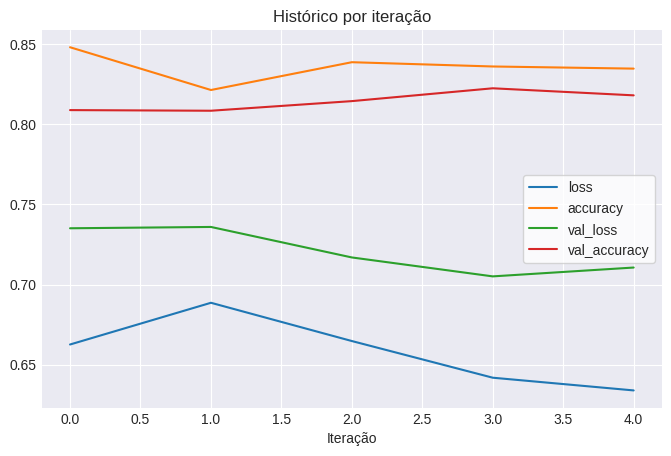

In [32]:
grafico_historico_por_iteracao(historico_03)

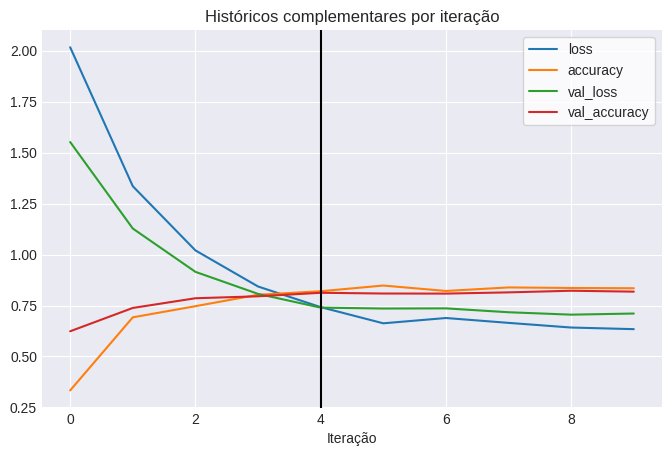

In [33]:
grafico_historicos_complementares(historico_02, historico_03)

## Criando Modelo_04

In [34]:
modelo_04 = modelo_02
modelo_04._name = "Modelo_04"

In [35]:
modelo_04.compile(loss=PERDA,
                  optimizer=Adam(learning_rate=APRENDIZADO_RESINTONIZADO),
                  metrics=METRICAS)

historico_04 = modelo_04.fit(dados_treino,
                             epochs=ITERACOES_RESINTONIZADAS,
                             steps_per_epoch=len(dados_treino),
                             initial_epoch=len(historico_02.epoch), # Inicia o treinamento após a última iteração do modelo_02
                             validation_data=dados_teste,
                             validation_steps=len(dados_teste),
                             callbacks=[criar_callback_tensorboard(diretorio='transfer_learning',
                                                                   experimento='modelo_04_completo_expandido_resintonizado')],
                             verbose=1)

Salvando log TensorBoard em: 'transfer_learning/modelo_04_completo_expandido_resintonizado/20230124-150934'.
Epoch 6/10
235/235 [==============================] - 60s 232ms/step - loss: 0.7849 - accuracy: 0.7761 - val_loss: 0.6561 - val_accuracy: 0.8240
Epoch 7/10
235/235 [==============================] - 59s 250ms/step - loss: 0.7345 - accuracy: 0.7836 - val_loss: 0.6001 - val_accuracy: 0.8388
Epoch 8/10
235/235 [==============================] - 49s 207ms/step - loss: 0.6978 - accuracy: 0.7935 - val_loss: 0.5927 - val_accuracy: 0.8284
Epoch 9/10
235/235 [==============================] - 47s 199ms/step - loss: 0.6678 - accuracy: 0.8052 - val_loss: 0.5507 - val_accuracy: 0.8496
Epoch 10/10
235/235 [==============================] - 42s 178ms/step - loss: 0.6485 - accuracy: 0.8051 - val_loss: 0.5307 - val_accuracy: 0.8468


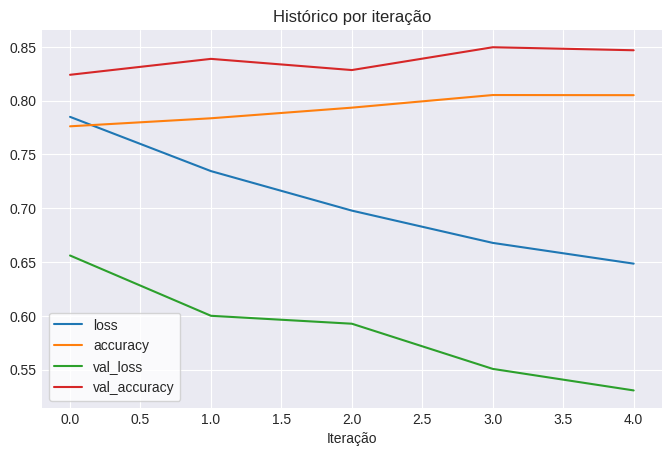

In [36]:
grafico_historico_por_iteracao(historico_04)

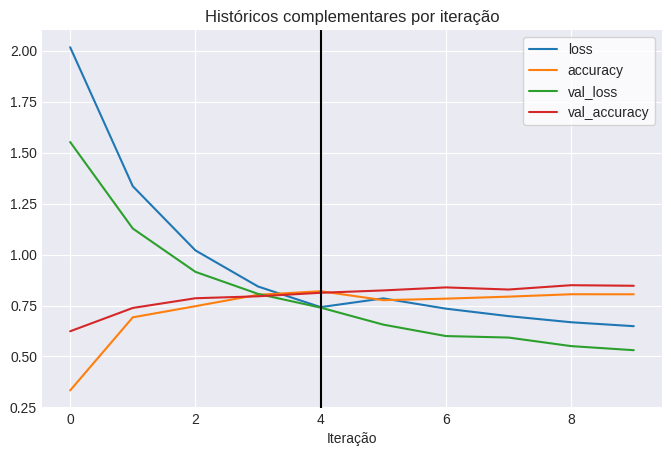

In [37]:
grafico_historicos_complementares(historico_02, historico_04)

## Comparando modelos utilizando TensorBoard

In [ ]:
# # Enviar resultados ao TensorBoard dev

# !tensorboard dev upload --logdir ./transfer_learning/ \
#                         --name "Expansão e sintonia fina com EfficientNetB0." \
#                         --description "Testes progressivos com dados parciais (1% e 10%) e completos, puros e expandidos, utilizando modelos EfficientNetB0 padrão e resintonizado. Base de dados Food101." \
#                         --one_shot

TensorBoard link: https://tensorboard.dev/experiment/nkvagaaPR6yLnmdTRQl6gw/